In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#Happy = pd.read_excel("WHR2018Chapter2OnlineData.xls")
#Happy2018 = Happy[Happy["year"]==2017]

In [2]:
orderedHappy2018 = pd.read_excel("Ordered Happy 2017.xls")

In [3]:
#Take out all nonNan data
num = orderedHappy2018.select_dtypes(exclude=['object'])
cols_with_no_nans = []
for col in num.columns:
    if not orderedHappy2018[col].isnull().any():   #df["col"].isnull().any()
        cols_with_no_nans.append(col)
target = pd.DataFrame(orderedHappy2018["Life Ladder"])
predictors = orderedHappy2018[cols_with_no_nans]

In [4]:
predictors.drop(["Standard deviation of ladder by country-year","Standard deviation/Mean of ladder by country-year"],axis=1,inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
predictors.drop(columns = ["Life Ladder"],inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Multivariate Data

In [6]:
jointDF = pd.concat([predictors,pd.DataFrame(orderedHappy2018["Life Ladder"])],axis=1)

## Rough plot to determine which kind of algorithm should be used

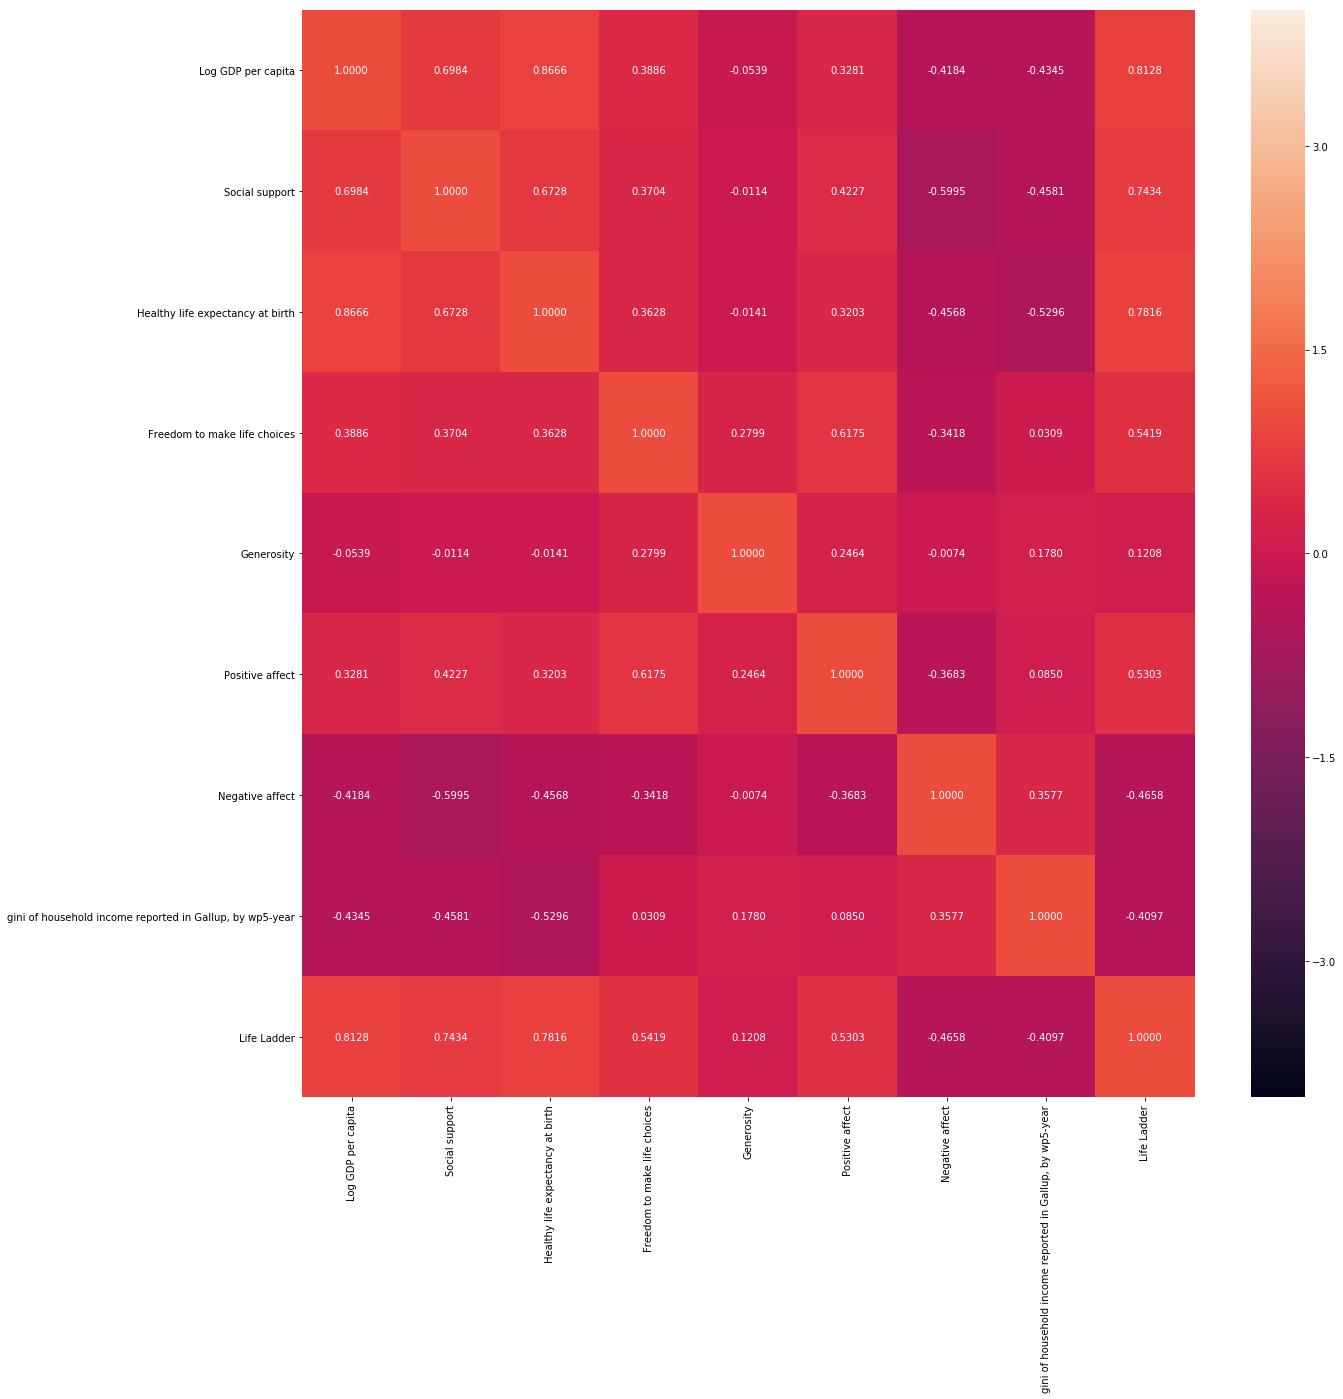

In [7]:
f, axes = plt.subplots(1,1,figsize=(20,20))
jointDF.corr()
sb.heatmap(jointDF.corr(), vmin = -4, vmax = 4,annot = True, fmt=".4f")

### Now we will use 3 clustering methods  
### -> DBSCAN, K-MEANS++, Gaussian Mixture Models

## Clustering Method 1 - DBSCAN

In [8]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [9]:
def dbscan_eps_sel(jointDF,eps):
    db = DBSCAN(eps=eps, min_samples=2).fit(jointDF)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    # #############################################################################
    # Plot result

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = jointDF[class_member_mask & core_samples_mask]
        plt.plot(xy.values[:, 0], xy.values[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = jointDF[class_member_mask & ~core_samples_mask]
        plt.plot(xy.values[:, 0], xy.values[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

In [10]:
#Identify number of  stable clusters

In [11]:
def stable_cluster(eps):
    db = DBSCAN(eps=eps, min_samples=2).fit(jointDF)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    return (n_clusters_,n_noise_)

In [50]:
cluster_eps_acc = pd.DataFrame(data = {},index = ["No of Clusters", "No of Noise"])
for i in range(70,80,1):
    a = stable_cluster(i/100)
    cluster_eps_acc[str(i/100)] = (a)
print(cluster_eps_acc)

                0.7  0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79
No of Clusters   20    20    21    21    21    21    18    18    19    20
No of Noise      58    57    54    52    52    50    50    50    46    44


## Clustering Method 2 - K-MEANS++

In [13]:
# Import essential models from sklearn
from sklearn.cluster import KMeans

In [14]:
# Vary the Number of Clusters
def elbow_plot(jointDF):
    min_clust = 1
    max_clust = 40
    init_algo = 'k-means++'

    # Compute Within Cluster Sum of Squares
    within_ss = []
    for num_clust in range(min_clust, max_clust+1):
        kmeans = KMeans(n_clusters = num_clust, init = init_algo, n_init = 5)
        kmeans.fit(jointDF)
        within_ss.append(kmeans.inertia_)

    # Elbow Plot : Within SS vs Number of Clusters
    f, axes = plt.subplots(1, 1, figsize=(16,4))
    plt.plot(range(min_clust, max_clust+1), within_ss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within Cluster Sum of Squares')
    plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
    plt.grid(which='major', axis='y')
    plt.show()

In [72]:
# Set "optimal" Clustering Parameters
num_clust = 10
new_num_clust = num_clust #to copy for database
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20)                 

# Fit the Clustering Model on the Data
kmeans.fit(jointDF)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### 0 = Life Ladder
#### 1 = Log GDP per capita
#### 2 = Social support
#### 3 = Healthy life expectancy at birth
#### 4 = Freedom to make life choices
#### 5 = Generosity
#### 6 = Positive affect
#### 7 = Negative affect
#### 8 = gini of household income reported in Gallup, by wp5-year

['Life Ladder', 'Log GDP per capita', 'Social support',
       'Healthy life expectancy at birth', 'Freedom to make life choices',
       'Generosity', 'Positive affect', 'Negative affect',
       'gini of household income reported in Gallup, by wp5-year']


In [73]:
# Print the Cluster Centers
def kmeans_pp_labeling(kmeans,jointDF):
    print("Features\t",end='')
    for i in range(9):
       print(i,"\t",end='')
    print()

    for i, center in enumerate(kmeans.cluster_centers_):
        print("Cluster", i, end=":\t")
        for coord in center:
            print(coord.round(2), end="\t")

        print()
    print()

    # Print the Within Cluster Sum of Squares
    print("Within Cluster Sum of Squares :", kmeans.inertia_)
    print()

    # Predict the Cluster Labels
    labels = kmeans.predict(jointDF)
    new_labels = labels.copy()
    # Append Labels to the Data
    jointDF_labeled = jointDF.copy()
    jointDF_labeled["Cluster"] = pd.Categorical(labels)

    # Summary of the Cluster Labels
    sb.countplot(jointDF_labeled["Cluster"])
    kmeans_cluster = jointDF_labeled["Cluster"].copy()
    return jointDF_labeled,labels

Features	0 	1 	2 	3 	4 	5 	6 	7 	8 	
Cluster 0:	9.95	0.85	68.6	0.79	-0.04	0.78	0.26	0.44	6.1	
Cluster 1:	8.1	0.7	53.97	0.65	0.01	0.64	0.3	0.54	4.11	
Cluster 2:	9.07	0.84	63.25	0.77	-0.05	0.71	0.24	0.43	5.43	
Cluster 3:	7.64	0.63	45.36	0.69	0.02	0.65	0.39	0.59	4.17	
Cluster 4:	10.68	0.89	74.88	0.75	-0.0	0.71	0.23	0.41	5.96	
Cluster 5:	10.64	0.92	71.91	0.87	0.07	0.77	0.24	0.39	6.9	
Cluster 6:	7.34	0.67	51.03	0.68	0.01	0.66	0.38	0.53	3.98	
Cluster 7:	9.07	0.8	60.52	0.8	0.02	0.69	0.37	0.43	5.1	
Cluster 8:	9.7	0.84	65.96	0.73	-0.08	0.67	0.3	0.41	5.46	
Cluster 9:	8.21	0.73	57.15	0.77	0.07	0.74	0.29	0.52	4.2	

Within Cluster Sum of Squares : 185.11760486907605



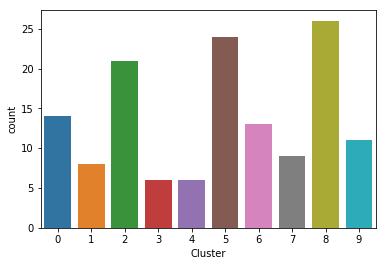

In [74]:
labeled_kmeans_pp_df, kmeans_pp_labels = kmeans_pp_labeling(kmeans,jointDF)

In [75]:
#Count the values of each cluster
labeled_kmeans_pp_df["Cluster"].value_counts()

8    26
5    24
2    21
0    14
6    13
9    11
7     9
1     8
4     6
3     6
Name: Cluster, dtype: int64

In [76]:
#Label of clusters for the 141 data
kmeans_pp_labels

array([6, 0, 0, 8, 5, 5, 2, 8, 2, 8, 5, 6, 7, 0, 9, 8, 8, 6, 9, 6, 5, 3,
       3, 0, 0, 2, 1, 6, 0, 8, 5, 5, 5, 2, 8, 7, 2, 8, 9, 5, 5, 9, 2, 5,
       1, 5, 2, 6, 1, 2, 4, 8, 5, 7, 7, 8, 7, 5, 5, 4, 3, 4, 2, 2, 9, 2,
       8, 2, 8, 0, 3, 6, 7, 8, 5, 8, 9, 1, 6, 5, 1, 8, 0, 2, 2, 8, 8, 9,
       7, 5, 5, 8, 6, 3, 5, 9, 2, 0, 2, 8, 7, 0, 5, 8, 2, 9, 2, 9, 8, 3,
       4, 0, 5, 1, 4, 6, 4, 5, 5, 2, 9, 8, 6, 8, 8, 7, 6, 2, 0, 5, 0, 0,
       2, 8, 8, 1, 1, 6])

In [78]:
#export file
labeled_kmeans_pp_df.to_excel("1716 test 10 cluster.xls")

In [79]:
#remove the column clusters
kmeans_pp_features = list(labeled_kmeans_pp_df.columns)
kmeans_pp_features.remove("Cluster")

In [80]:
kmeans_pp_features

['Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Positive affect',
 'Negative affect',
 'gini of household income reported in Gallup, by wp5-year',
 'Life Ladder']

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


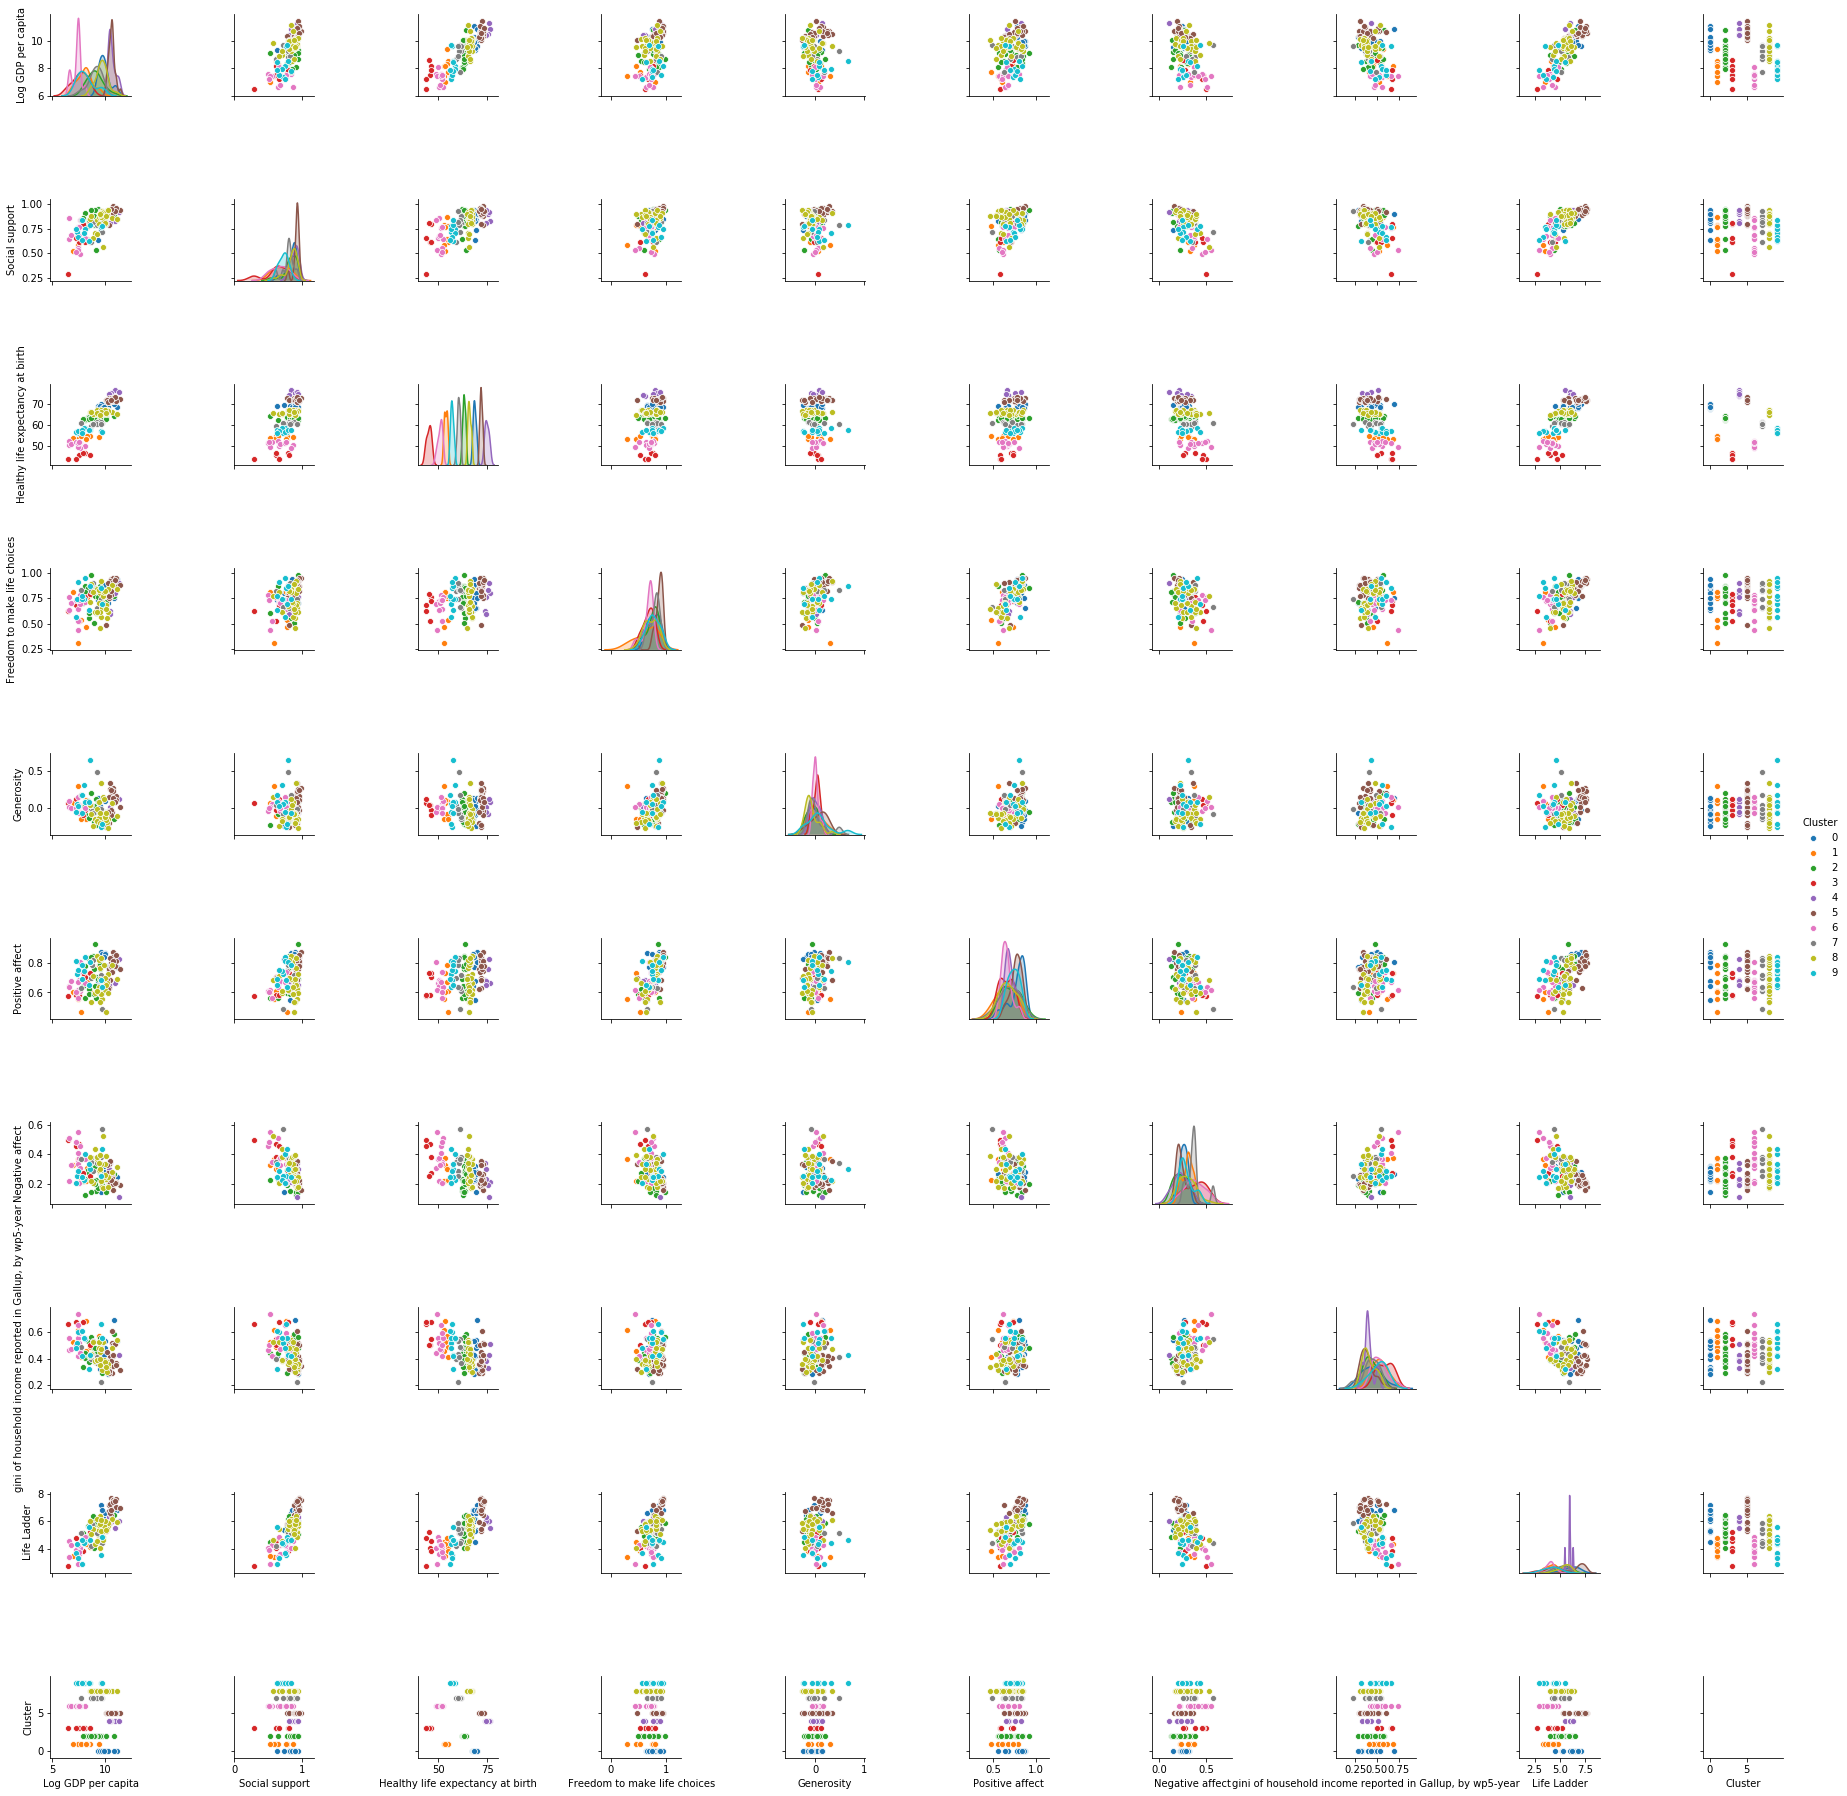

In [81]:
# Plot the Clusters on 2D grids
sb.pairplot(labeled_kmeans_pp_df, vars = labeled_kmeans_pp_df.columns.values, hue = "Cluster")

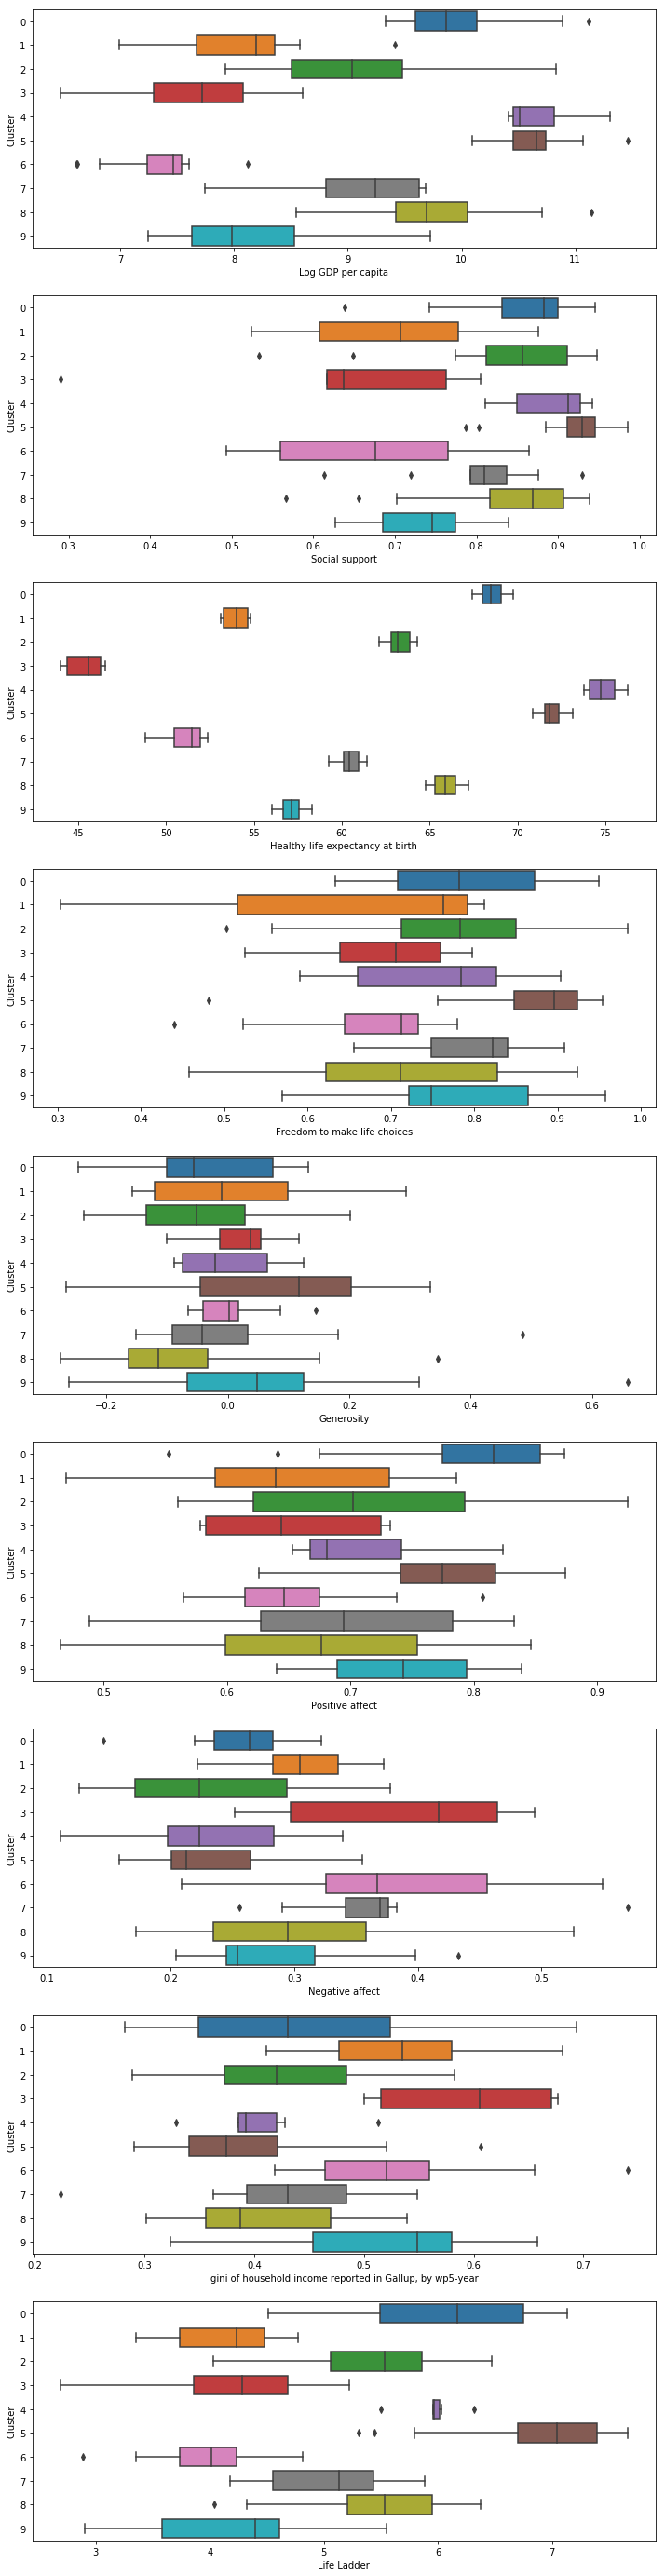

In [82]:
# Boxplots for all Features against the Clusters
f, axes = plt.subplots(len(kmeans_pp_features), 1, figsize=(12,50))
#no need boxplot for year
for i in range(len(kmeans_pp_features)):
    sb.boxplot(x = kmeans_pp_features[i], y = 'Cluster', data = labeled_kmeans_pp_df, ax = axes[i])


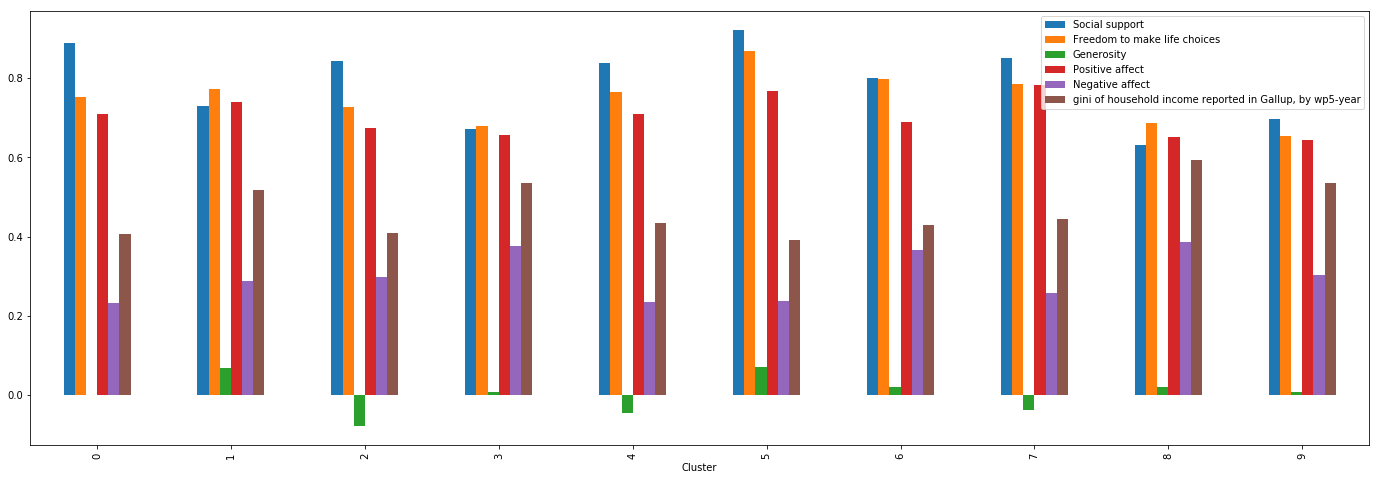

In [30]:
# Average Behaviour of each Cluster
cluster_data_kmeans_pp = pd.DataFrame(labeled_kmeans_pp_df.drop(columns=["Healthy life expectancy at birth","Log GDP per capita","Life Ladder"], inplace = False).groupby(by = "Cluster").mean())
cluster_data_kmeans_pp.plot.bar(figsize = (24,8))

## Clustering Method 3 - Gaussian Mixture Cluster (GMM)

In [31]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components =10)
gmm.fit(jointDF)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [32]:
# Predict the Cluster Labels
def gmm_labeling(gmm,jointDF):
    labels = gmm.predict(jointDF)
    new_labels = labels.copy()
    # Append Labels to the Data
    jointDF_labeled = jointDF.copy()
    jointDF_labeled["Cluster"] = pd.Categorical(labels)

    # Summary of the Cluster Labels
    sb.countplot(jointDF_labeled["Cluster"])
    gmm_cluster = jointDF_labeled["Cluster"].copy()
    return jointDF_labeled,labels

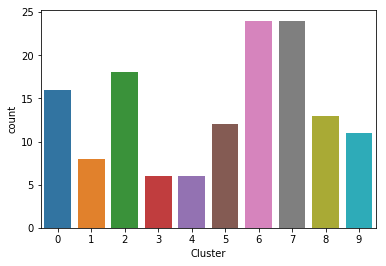

In [33]:
labeled_gmm_df, gmm_labels = gmm_labeling(gmm,jointDF)

In [34]:
#Count the values of each cluster
labeled_gmm_df["Cluster"].value_counts()

7    24
6    24
2    18
0    16
8    13
5    12
9    11
1     8
4     6
3     6
Name: Cluster, dtype: int64

In [35]:
#Label of clusters for the 141 data
gmm_labels

array([8, 0, 0, 6, 7, 7, 2, 6, 9, 6, 7, 8, 9, 0, 5, 6, 6, 8, 5, 8, 7, 4,
       4, 0, 0, 2, 1, 8, 0, 6, 7, 7, 7, 2, 0, 9, 2, 0, 5, 7, 7, 5, 2, 7,
       1, 7, 2, 8, 1, 2, 3, 6, 7, 5, 9, 6, 9, 7, 7, 3, 4, 3, 2, 2, 5, 9,
       6, 2, 6, 0, 4, 8, 9, 6, 7, 6, 5, 1, 8, 7, 1, 6, 0, 2, 9, 6, 6, 5,
       9, 7, 7, 6, 8, 4, 7, 5, 2, 0, 2, 6, 9, 0, 7, 6, 2, 5, 2, 5, 6, 4,
       3, 0, 7, 1, 3, 8, 3, 7, 7, 2, 5, 6, 8, 6, 6, 9, 8, 2, 0, 7, 0, 0,
       2, 6, 6, 1, 1, 8], dtype=int32)

In [36]:
# Boxplots for all Features against the Clusters
gmm_features = list(labeled_gmm_df.columns)
gmm_features.remove("Cluster")

In [37]:
gmm_features

['Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Positive affect',
 'Negative affect',
 'gini of household income reported in Gallup, by wp5-year',
 'Life Ladder']

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


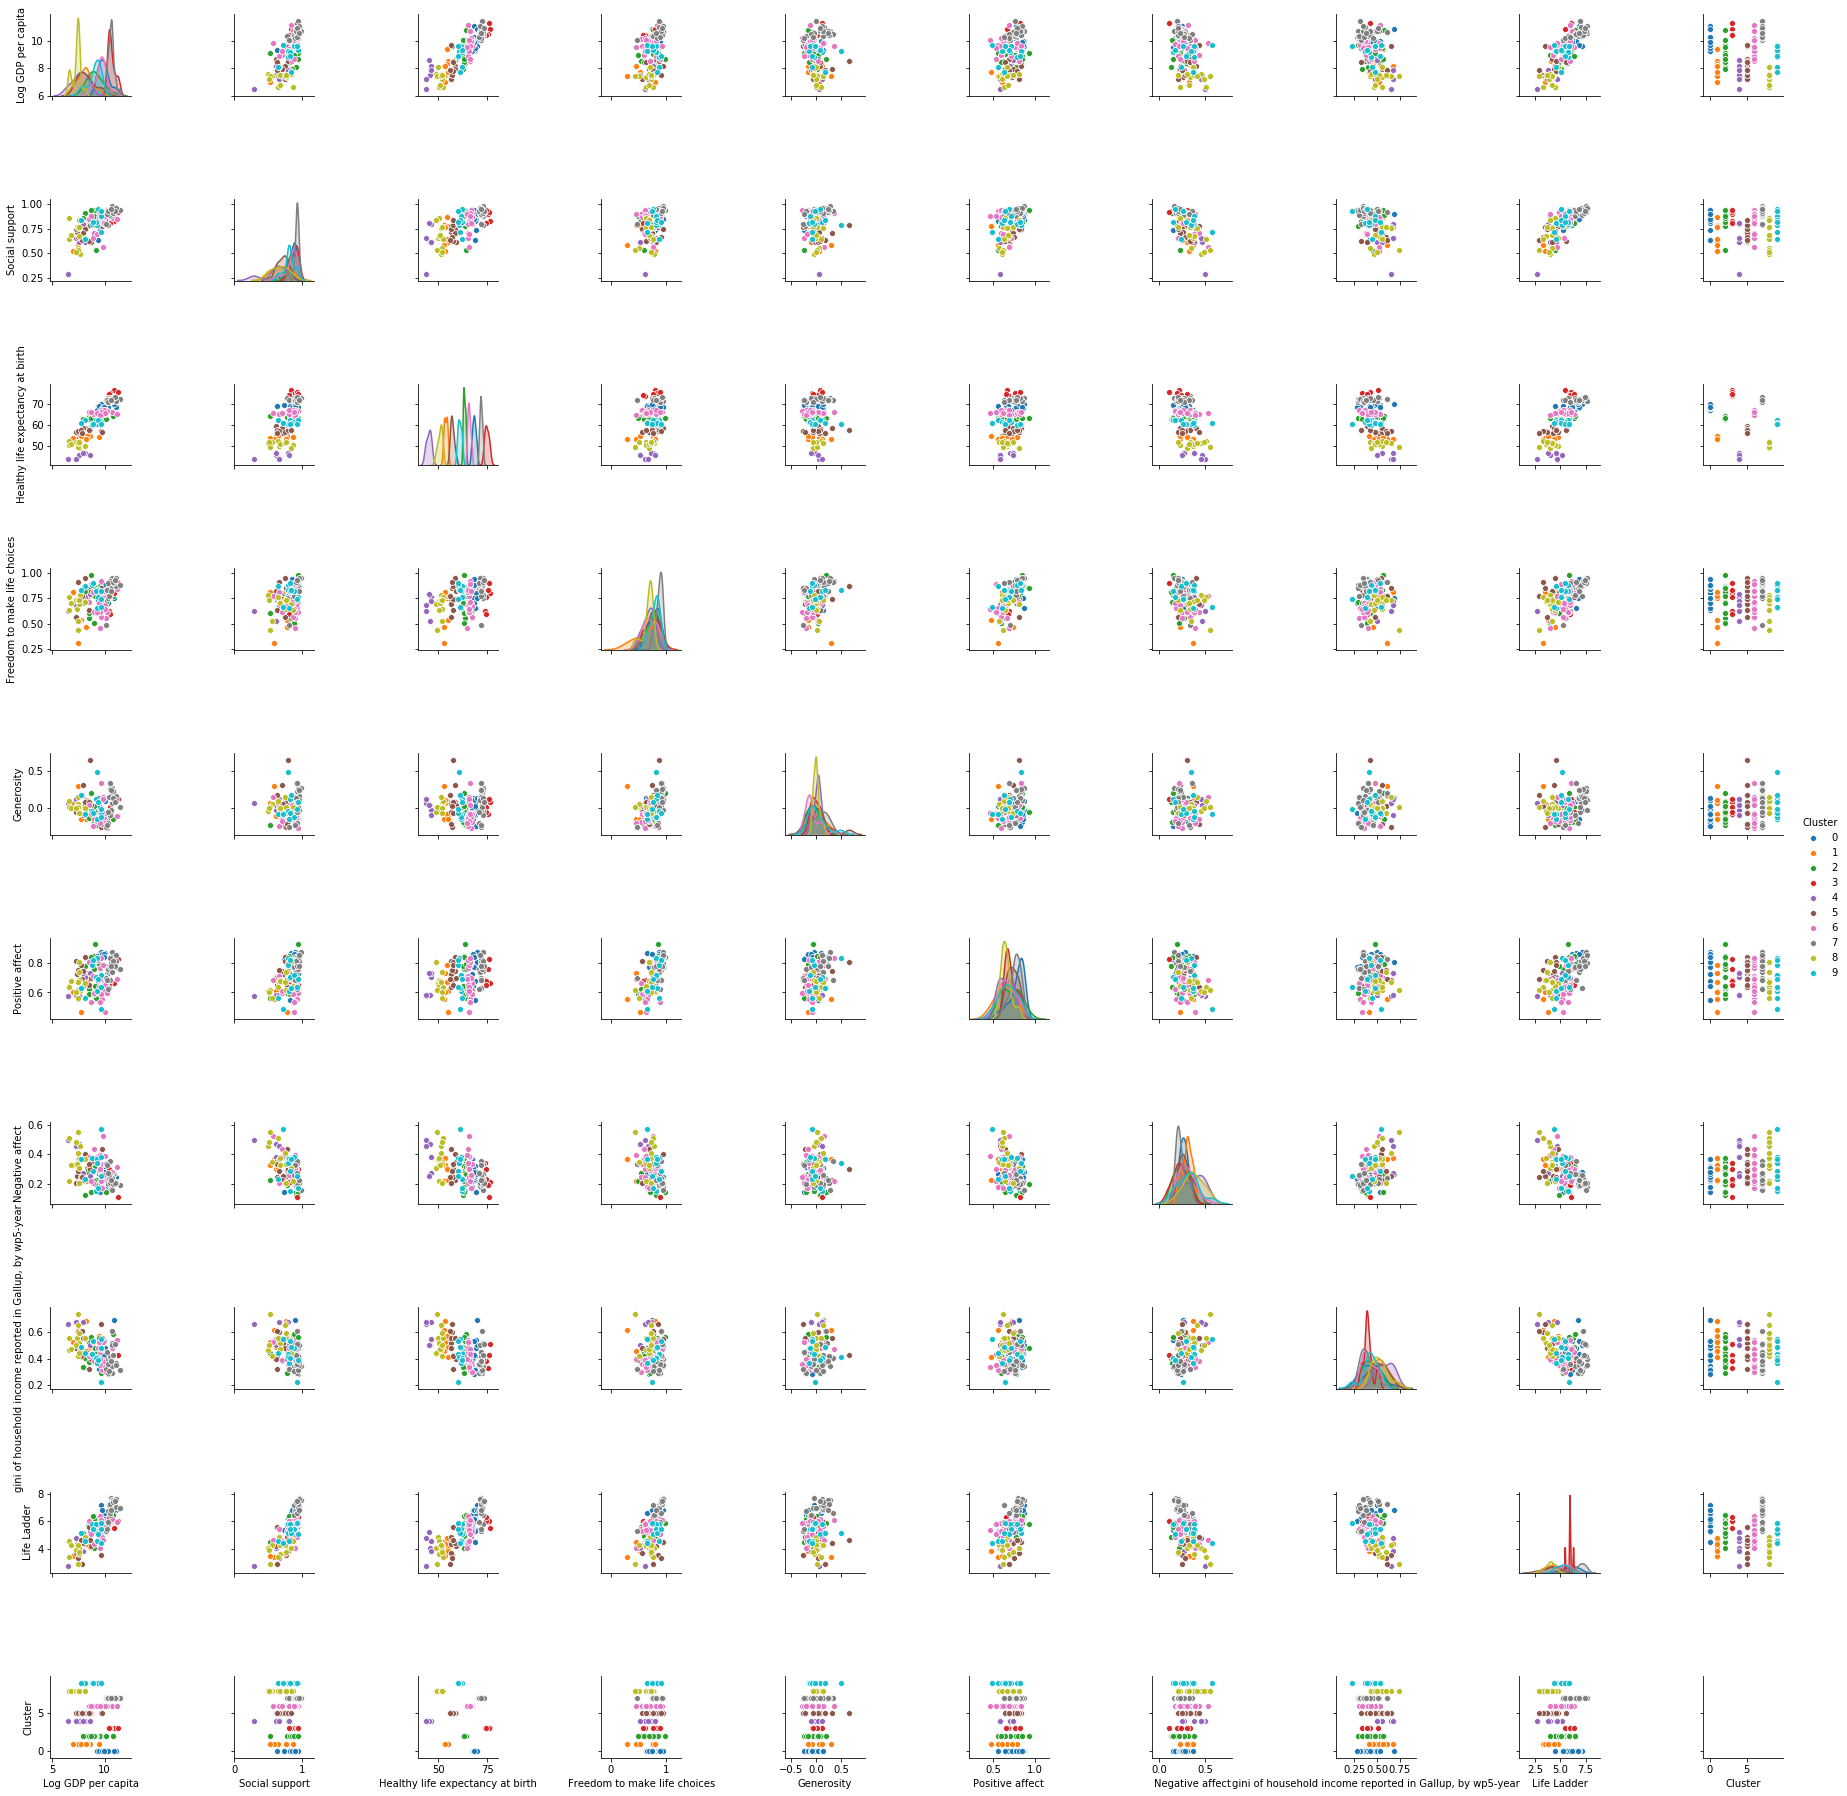

In [38]:
# Plot the Clusters on 2D grids
sb.pairplot(labeled_gmm_df, vars = labeled_gmm_df.columns.values, hue = "Cluster")

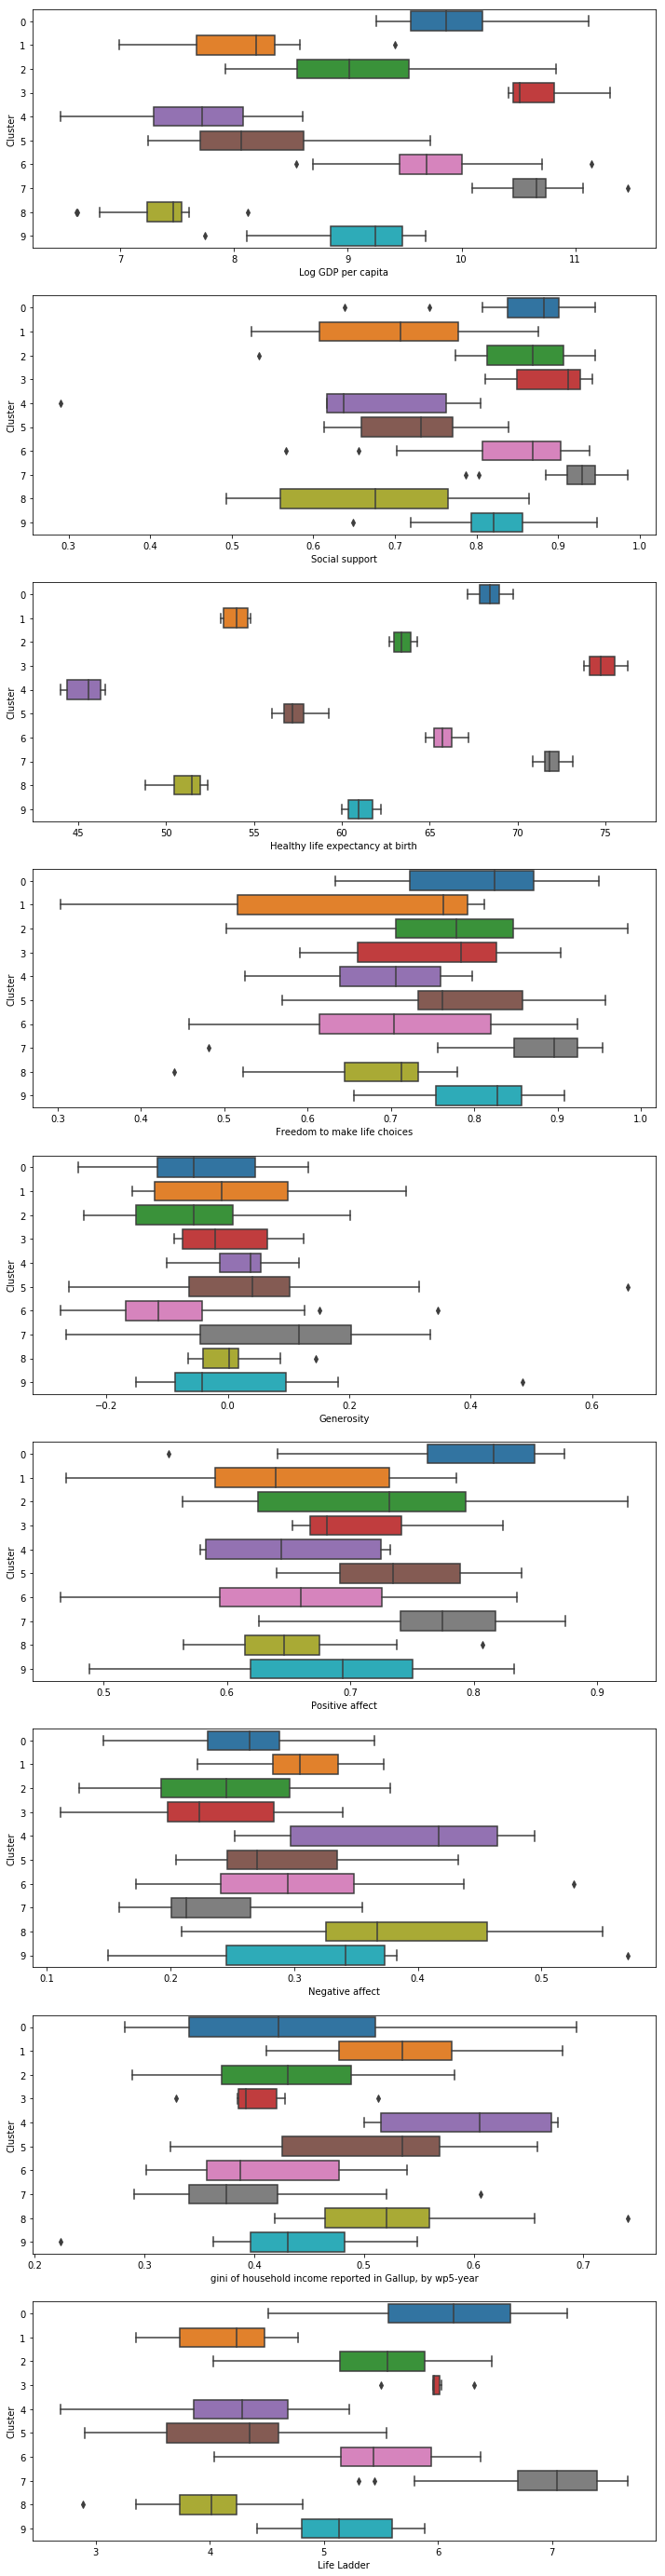

In [40]:
f, axes = plt.subplots(len(gmm_features), 1, figsize=(12,50))
#no need boxplot for year
for i in range(len(gmm_features)):
    sb.boxplot(x = gmm_features[i], y = 'Cluster', data = labeled_gmm_df, ax = axes[i])

In [41]:
#write new columns to excel file (database)
def update_kmeans(filename):
    new = pd.read_excel(filename)
    new_column_name = "Cluster " +str(new_num_clust)
    new[new_column_name] = new_labels
    new.to_excel(filename)

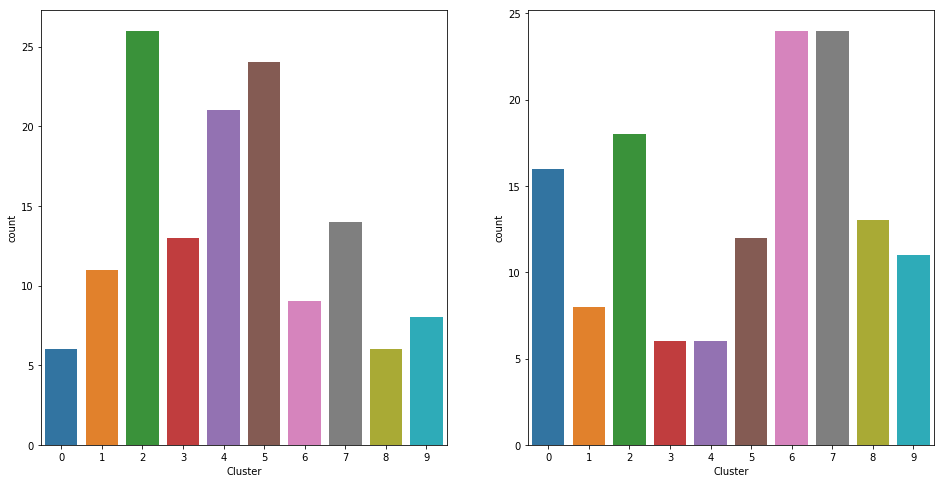

In [42]:
# Summary of the Cluster Labels
f,axes = plt.subplots(1,2,figsize = (16,8))
sb.countplot(labeled_kmeans_pp_df["Cluster"], ax = axes[0])
sb.countplot(labeled_gmm_df["Cluster"], ax = axes[1])